# Classification

Notebook for classification tasks

Plan:
- Load data
- Train/test split
- Baseline model (Logistic Regression)
- Metrics: accuracy, precision, recall, F1, ROC-AUC


In [36]:
# Я начинаю проект: подключаю базовые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)



In [38]:
# Загружаю train.csv
df = pd.read_csv("train.csv")

# Смотрю размер (строки, столбцы)
print("Размер df:", df.shape)

# Смотрю первые строки
df.head()

Размер df: (323871, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [39]:
# Проверяю, что id реально удалился
print("Размер после удаления id:", df.shape)

# Смотрю распределение целевого признака (сколько 0 и 1)
print(df["target"].value_counts())

# Смотрю доли (проценты), чтобы понять дисбаланс
print(df["target"].value_counts(normalize=True))


Размер после удаления id: (323871, 59)
target
0    312093
1     11778
Name: count, dtype: int64
target
0    0.963634
1    0.036366
Name: proportion, dtype: float64


In [40]:
# Считаю, сколько -1 в каждом столбце (это "пропуски" в этом датасете)
minus_ones = (df == -1).sum().sort_values(ascending=False)

# Покажу топ-10 столбцов с наибольшим количеством -1
print(minus_ones.head(10))


ps_car_03_cat    223844
ps_car_05_cat    145174
ps_reg_03         58835
ps_car_14         23121
ps_car_07_cat      6181
ps_ind_05_cat      3165
ps_car_09_cat       300
ps_ind_02_cat       110
ps_car_01_cat        58
ps_ind_04_cat        42
dtype: int64


In [41]:
df = df.replace(-1, np.nan)


In [42]:
# Удаляю столбец с огромным количеством пропусков
df = df.drop(columns=['ps_car_03_cat'])

print("Размер после удаления ps_car_03_cat:", df.shape)

Размер после удаления ps_car_03_cat: (323871, 58)


In [43]:
# Признаки (всё кроме target)
X = df.drop(columns=['target'])

# Цель
y = df['target']

# Делим на train и valid, чтобы доля единиц сохранилась (из-за дисбаланса)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train:", X_train.shape, "valid:", X_valid.shape)
print("Доля класса 1 в train:", y_train.mean())
print("Доля класса 1 в valid:", y_valid.mean())

train: (259096, 57) valid: (64775, 57)
Доля класса 1 в train: 0.03636489949671164
Доля класса 1 в valid: 0.03637205712080278


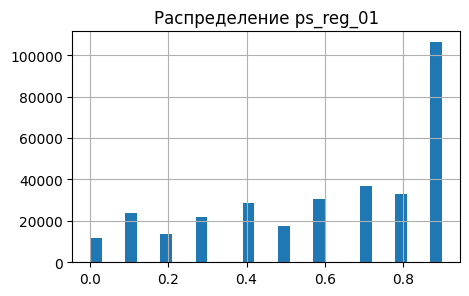

In [44]:
import matplotlib.pyplot as plt

# пример числового признака
col_num = "ps_reg_01"

plt.figure(figsize=(5,3))
df[col_num].replace(-1, None).dropna().hist(bins=30)
plt.title(f"Распределение {col_num}")
plt.show()


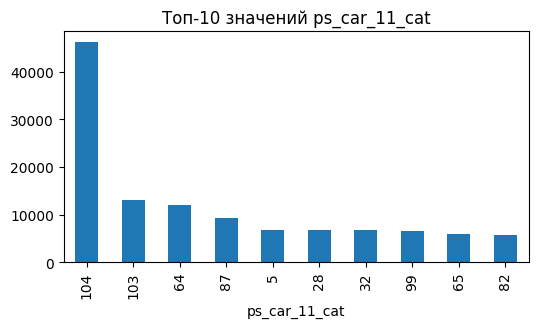

In [45]:
col_cat = "ps_car_11_cat"

vc = df[col_cat].replace(-1, None).dropna().value_counts().head(10)

plt.figure(figsize=(6,3))
vc.plot(kind="bar")
plt.title(f"Топ-10 значений {col_cat}")
plt.show()


In [46]:
import numpy as np

# Временно заменяем -1 на NaN, чтобы корреляция считалась корректно
df_corr = df.replace(-1, np.nan)

# Берем только числовые столбцы
corr = df_corr.corr(numeric_only=True)

# Корреляция с target
corr_target = corr["target"].abs().sort_values(ascending=False)

print("Топ-10 признаков по |корреляции| с target:")
print(corr_target.iloc[1:11])  # первый — это сам target


Топ-10 признаков по |корреляции| с target:
ps_car_13        0.054349
ps_car_12        0.038314
ps_ind_17_bin    0.037068
ps_reg_02        0.035323
ps_ind_07_bin    0.034748
ps_reg_03        0.034168
ps_ind_06_bin    0.033958
ps_car_04_cat    0.033653
ps_ind_05_cat    0.033412
ps_car_02_cat    0.032679
Name: target, dtype: float64


In [47]:
# id — это просто идентификатор строки, модели он не помогает
if "id" in df.columns:
    df = df.drop(columns=["id"])


In [48]:
import numpy as np

# Заменяем -1 на NaN
df = df.replace(-1, np.nan)


In [49]:
# X — все признаки
X = df.drop(columns=["target"])

# y — целевая переменная
y = df["target"]


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [51]:
print("Размеры выборок:")
print("Train:", X_train.shape)
print("Valid:", X_valid.shape)

print("\nДоля target=1:")
print("Train:", y_train.mean())
print("Valid:", y_valid.mean())


Размеры выборок:
Train: (259096, 56)
Valid: (64775, 56)

Доля target=1:
Train: 0.03636489949671164
Valid: 0.03637205712080278


In [52]:
# Заполняем NaN отдельно для train и valid (ВАЖНО!)
for col in X_train.columns:
    if X_train[col].dtype in ["float64", "int64"]:
        median = X_train[col].median()
        X_train[col] = X_train[col].fillna(median)
        X_valid[col] = X_valid[col].fillna(median)


In [53]:
# 1) Копия, чтобы не портить исходные X_train / X_valid
X_train_lr = X_train.copy()
X_valid_lr = X_valid.copy()

# 2) Заполняем NaN медианой, посчитанной ТОЛЬКО на train (это важно)
medians = X_train_lr.median(numeric_only=True)
X_train_lr = X_train_lr.fillna(medians)
X_valid_lr = X_valid_lr.fillna(medians)

# 3) Обучаем baseline-модель
lr = LogisticRegression(
    class_weight="balanced",
    max_iter=2000,
    n_jobs=-1
)

lr.fit(X_train_lr, y_train)
print("LogReg обучилась ✅")


LogReg обучилась ✅


In [54]:
# Вероятности класса 1
y_valid_proba = lr.predict_proba(X_valid_lr)[:, 1]

auc = roc_auc_score(y_valid, y_valid_proba)
gini = 2 * auc - 1

print(f"ROC-AUC: {auc:.5f}")
print(f"Gini:    {gini:.5f}")


ROC-AUC: 0.62043
Gini:    0.24087


In [55]:
# Класс по порогу 0.5
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

prec = precision_score(y_valid, y_valid_pred, zero_division=0)
rec = recall_score(y_valid, y_valid_pred, zero_division=0)
f1 = f1_score(y_valid, y_valid_pred, zero_division=0)

print(f"Precision (class=1): {prec:.5f}")
print(f"Recall    (class=1): {rec:.5f}")
print(f"F1        (class=1): {f1:.5f}")


Precision (class=1): 0.05246
Recall    (class=1): 0.54244
F1        (class=1): 0.09567


Confusion Matrix:
[[39336 23083]
 [ 1078  1278]]


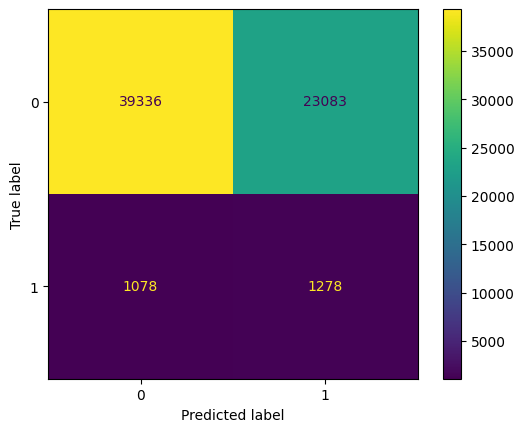

In [56]:
cm = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


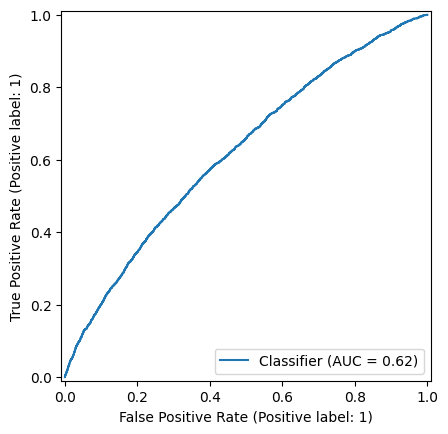

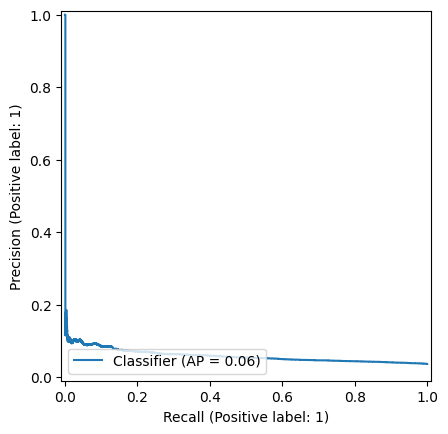

In [65]:
RocCurveDisplay.from_predictions(y_valid, y_valid_proba)
PrecisionRecallDisplay.from_predictions(y_valid, y_valid_proba)


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_valid_proba_rf = rf.predict_proba(X_valid)[:, 1]

auc_rf = roc_auc_score(y_valid, y_valid_proba_rf)
gini_rf = 2 * auc_rf - 1

print(f"RF ROC-AUC: {auc_rf:.5f}")
print(f"RF Gini:    {gini_rf:.5f}")




RF ROC-AUC: 0.63028
RF Gini:    0.26057


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_valid_proba_rf = rf.predict_proba(X_valid)[:, 1]

auc_rf = roc_auc_score(y_valid, y_valid_proba_rf)
gini_rf = 2 * auc_rf - 1

print(f"RF ROC-AUC: {auc_rf:.5f}")
print(f"RF Gini:    {gini_rf:.5f}")

RF ROC-AUC: 0.63034
RF Gini:    0.26069


In [59]:
!pip install lightgbm


In [72]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

lgb_model = lgb.LGBMClassifier(
    n_estimators=2000,          # много, но остановимся раньше
    learning_rate=0.03,
    num_leaves=63,              # КЛЮЧ
    max_depth=-1,
    min_child_samples=30,       # регуляризация
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",    # ВАЖНО: вместо scale_pos_weight
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

y_valid_proba = lgb_model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_valid_proba)
gini = 2 * auc - 1

print("LGBM ROC-AUC:", round(auc, 5))
print("LGBM Gini:", round(gini, 5))
print("Best iteration:", lgb_model.best_iteration_)



[LightGBM] [Info] Number of positive: 9422, number of negative: 249674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 259096, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.632641	valid_0's binary_logloss: 0.626975
LGBM ROC-AUC: 0.63264
LGBM Gini: 0.26528
Best iteration: 122
